In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [3]:
data=pd.read_csv('data_train_prepared_level4.csv' )
data.shape

(14684773, 42)

In [4]:
data_test=pd.read_csv('data_test_prepared_level3.csv' )
data_test.shape

(144156, 42)

In [5]:
frames = [data, data_test]

df = pd.concat(frames)

In [6]:
df.beginning_of_week.tail(5)

144151    2020-07-05
144152    2020-07-05
144153    2020-07-05
144154    2020-07-05
144155    2020-07-05
Name: beginning_of_week, dtype: object

In [7]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.beginning_of_week.min())
print('The time series ends on: ', df.beginning_of_week.max())

Number of rows and columns after removing missing values: (14828929, 43)
The time series starts from:  2018-06-03
The time series ends on:  2020-07-05


### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

In [8]:
stat, p = stats.normaltest(df.total_sales)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=22478856.346, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: 441.3219886587582
Skewness of normal distribution: 8.527884410530895


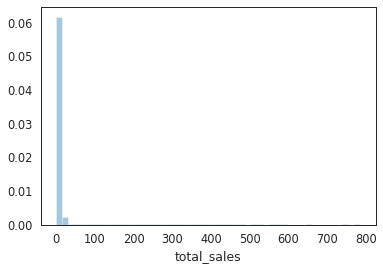

In [9]:
# print(df.Global_active_power.describe())
sns.distplot(df.total_sales);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.total_sales)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.total_sales)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

### First Time series plot

In [10]:
df1=df.loc[:,['beginning_of_week','total_sales']]
df1.set_index('beginning_of_week',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('total_sales')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Total Sales Time Series')
sns.despine(top=True)
plt.show();

### Global Active Power Distribution

count   mean    std    min    25%    50%    75%      max
total_sales 14828929.0000 1.7999 4.8156 0.0000 0.0000 0.0000 0.0000 786.0000

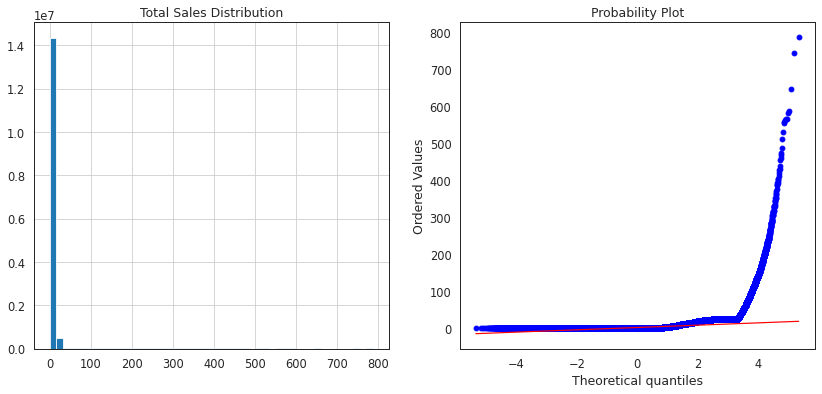

In [11]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['total_sales'].hist(bins=50)
plt.title('Total Sales Distribution')

plt.subplot(1,2,2)
stats.probplot(df['total_sales'], plot=plt);
df1.describe().T

In [12]:
del df['beginning_of_week']

## LSTM



Create dataset, normalize the dataset, split into training and test sets, convert an array of values into a dataset matrix

In [13]:
dataset = df.total_sales.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [14]:
train_size = 14684773
train_size

14684773

In [15]:
test_size = len(dataset) - train_size
test_size

144156

In [16]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [17]:
train.shape  , test.shape

((14684773, 1), (144156, 1))

In [18]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [19]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train , look_back)
X_test, Y_test = create_dataset(test , look_back)

In [20]:
X_train.shape

(14684742, 30)

In [21]:
X_train.shape , Y_train.shape , X_test.shape , Y_test.shape

((14684742, 30), (14684742,), (144125, 30), (144125,))

In [22]:
18000/144125

0.12489158716392021

In [23]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Model Architecture

In [24]:
X_train.shape

(14684742, 1, 30)

In [25]:
X_train.shape[0]

14684742

# MLP for Time Series Forecasting

In [26]:

optimizerq=keras.optimizers.Adam(0.001)

model = Sequential()
model.add(LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=optimizerq)

history = model.fit(X_train, Y_train, epochs=20, batch_size=10000, 
                    verbose=1, shuffle=True)

# Training Phase
model.summary()










Epoch 1/20
14684742/14684742 [==============================] - 26s 2us/step - loss: 1.7873e-05
Epoch 2/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7730e-05
Epoch 3/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7722e-05
Epoch 4/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7722e-05
Epoch 5/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7717e-05
Epoch 6/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7715e-05
Epoch 7/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7716e-05
Epoch 8/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7713e-05
Epoch 9/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7712e-05
Epoch 10/20
14684742/14684742 [==============================] - 25s 2us/step - loss: 1.7715e-05
Epoch 11/20
14684742/14684742 [========

In [27]:
# make predictions
# train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
# train_predict = scaler.inverse_transform(train_predict)
# Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_new = scaler.inverse_transform([Y_test]) 


import numpy as np



EPSILON = 1e-10

def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error

    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))


# print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
# print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test_new[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_new[0], test_predict[:,0])))
print('TEST Symmetric Mean Absolute Percentage Error :', smape(Y_test_new,test_predict[:,0]))

Test Mean Absolute Error: 2.7956977975583617
Test Root Mean Squared Error: 11.98539341609348
TEST Symmetric Mean Absolute Percentage Error : 1.6694039784431451


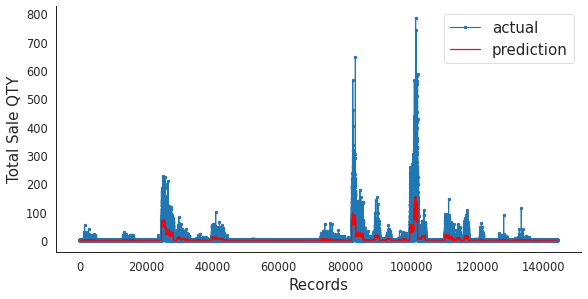

In [29]:
aa=[x for x in range(144125)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test_new[0][:144125], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:144125], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Total Sale QTY', size=15)
plt.xlabel('Records', size=15)
plt.legend(fontsize=15)
plt.show();

In [30]:




col = [ "subclass_id", "node", "beginning_of_week", "is_holiday", "total_sales"]
data_train_prediction= pd.read_csv('data_test_prepared_level1.csv'  , usecols =col)
test_predict = np.around(test_predict)
predic_t=pd.DataFrame(test_predict[:,0] )
predic_t.columns = ['Qty_prediction']
data_train_prediction['Qty_prediction'] = predic_t['Qty_prediction']



In [ ]:
data_train_prediction.head(5)

In [38]:
data_train_prediction.Qty_prediction = data_train_prediction['Qty_prediction'].abs()

In [39]:
data_train_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144156 entries, 0 to 144155
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   total_sales        144156 non-null  float64
 1   is_holiday         144156 non-null  int64  
 2   node               144156 non-null  int64  
 3   subclass_id        144156 non-null  object 
 4   beginning_of_week  144156 non-null  object 
 5   Qty_prediction     144125 non-null  float32
dtypes: float32(1), float64(1), int64(2), object(2)
memory usage: 6.0+ MB


In [40]:
data_train_prediction.head(5)

total_sales  is_holiday  node subclass_id beginning_of_week  Qty_prediction
0       0.0000           0  1304    15-10-10        2020-07-05          0.0000
1       0.0000           0  1359    15-10-10        2020-07-05          0.0000
2       0.0000           0  1085    15-10-10        2020-07-05          0.0000
3       0.0000           0  1095    15-10-10        2020-07-05          0.0000
4       0.0000           0  1222    15-10-10        2020-07-05          0.0000

In [41]:
from google.cloud import bigquery
client = bigquery.Client()
table_id = 'kohls-merch-in-lle.FUSE_LOCAL_TEST.DEMAND_TRAINING_15_543_WALKIN_Pre_Week_update'
# Since string columns use the "object" dtype, pass in a (partial) schema
# to ensure the correct BigQuery data type.
job_config = bigquery.LoadJobConfig(schema=[
    bigquery.SchemaField("total_sales", "float" ,  'NULLABLE', None, ()),
    bigquery.SchemaField("is_holiday", "integer" ,  'NULLABLE', None, ()),
    bigquery.SchemaField("node", "integer" ,  'NULLABLE', None, ()),
    bigquery.SchemaField("subclass_id", "STRING" ,  'NULLABLE', None, ()),
    bigquery.SchemaField("beginning_of_week", "STRING" ,  'NULLABLE', None, ()),
    bigquery.SchemaField("Qty_prediction", "float" ,  'NULLABLE', None, ())])
    
job = client.load_table_from_dataframe(
    data_train_prediction, table_id, job_config=job_config
)

# Wait for the load job to complete.
job.result()

In [44]:
7431+4497+5269+6213+2887+3240+2810+1385+674+82

34488

In [47]:
34488/144000

0.2395

In [42]:
data_train_prediction.shape

(144156, 6)

In [43]:
data_train_prediction.to_csv('our_result.csv', index = False)

In [34]:
data_train_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144156 entries, 0 to 144155
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   total_sales        144156 non-null  float64
 1   is_holiday         144156 non-null  int64  
 2   node               144156 non-null  int64  
 3   subclass_id        144156 non-null  object 
 4   beginning_of_week  144156 non-null  object 
 5   Qty_prediction     144125 non-null  float32
dtypes: float32(1), float64(1), int64(2), object(2)
memory usage: 6.0+ MB
